# Importing libraries

In [292]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-darkgrid')
tqdm.pandas()

# Loading the data
The warning is fine because columns with mixed types get converted to objects. 
We'll make sure everything has the right type in the next cell.

In [6]:
nrows = 10000 #Sizing down the dataset is useful for prototyping and evaluating computational times
df = pd.read_csv('Fire_Department_Calls_for_Service.csv', nrows=nrows)

# Data cleaning 
Everything not explicitly handled here should have type "object"

In [10]:
#Data dictionary so we can make sure everything is the right type
data_dict = pd.read_csv('DataDictionary.csv')

#List of datetime columns
date_columns = list(data_dict[data_dict['Data Type'] == 'Date & Time']['Field Name'])

#This column appears to be missing
date_columns.remove('AVL Validated On Scene DtTm')

#Converting to datetimes
for column in date_columns:
    #Specifying the formats makes date parsing way faster even though it's not elegant
    if "Date" in column:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y')
    else:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %I:%M:%S %p')
        
#List of numeric columns
numeric_columns = list(data_dict[data_dict['Data Type'] == 'Numeric']['Field Name'])

#Really these should be ints, but the float type lets us leave missing values as nans
df[numeric_columns] = df[numeric_columns].astype(float)
       
#List of boolean columns
bool_columns = list(data_dict[data_dict['Data Type'] == 'Boolean (True/False)']['Field Name'])
df[bool_columns] = df[bool_columns].astype(bool)

#Serialize the cleaned dataframe so we don't have to wait as long if we need to reload data
df.to_pickle('cleaned_fire_data')
        

# Task 1

## Adding turnout time and hour of day to dataframe

In [125]:
#Simple subtraction of response timestamp (enroute) and dispatch timestamp
df['turnout_time'] = df['Response DtTm'] - df['Dispatch DtTm']

#Converting the time delta to seconds
df['turnout_time'] = df['turnout_time'].progress_apply(lambda x: x.total_seconds())

#Adding hour of day based on when the call was received
df['hour'] = df['Received DtTm'].progress_apply(lambda x: x.hour)

#Adding boolean variable that indicates whether call is recieved during daytime or evening hours
daytime_hours = np.arange(6,22)
df['daytime'] = df['hour'].isin(daytime_hours)

100%|██████████| 10000/10000 [00:00<00:00, 262855.35it/s]


## Making a new dataframe containing only rows where the turnout time is defined

In [126]:
turnout_df = df[~np.isnan(df['turnout_time'])].reset_index(drop=True)

## What does the distribution of turnout times look like?
It's skewed right

Text(0, 0.5, 'Frequency')

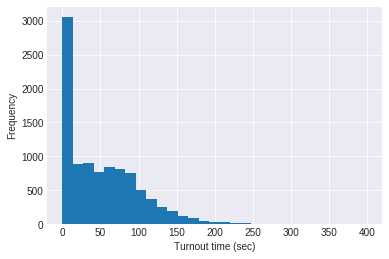

In [43]:
plt.hist(turnout_df['turnout_time'], bins=np.linspace(0,400,30))
plt.xlabel('Turnout time (sec)')
plt.ylabel('Frequency')

## Median turnout time by hour of day
I chose the median over the mean because of the skewness of the data and the presence of outliers

Text(0, 0.5, 'Median turnout time (sec)')

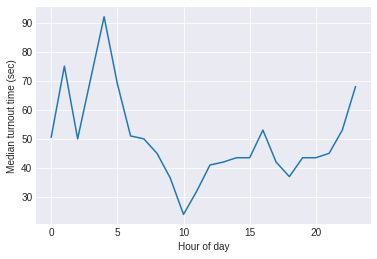

In [46]:
median_turnout = turnout_df[['hour','turnout_time']].groupby('hour').aggregate(np.median).reset_index()
plt.plot(median_turnout['hour'], median_turnout['turnout_time'])
plt.xlabel('Hour of day')
plt.ylabel('Median turnout time (sec)')

## CDF plot to compare daytime vs. evening turnout times
As expected, turnout times are generally longer for evening calls, but the previous plot reveals a spike 
specifically between 4:00-5:00 AM

Text(0, 0.5, 'Percentile')

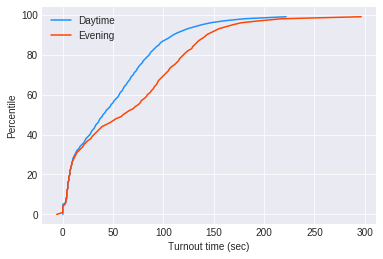

In [58]:
percentiles = np.arange(0,100)
daytime_values = np.percentile(turnout_df[turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(daytime_values, percentiles, color='dodgerblue')
evening_values = np.percentile(turnout_df[~turnout_df['daytime']]['turnout_time'], percentiles)
plt.plot(evening_values, percentiles, color='orangered')
plt.legend(['Daytime', 'Evening'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

## Looking at back to back responses

In [176]:
#adding "last available" column
turnout_df = turnout_df.sort_values(by='Available DtTm')
turnout_df['last_available'] = turnout_df.groupby('Unit ID')['Available DtTm'].transform(lambda x: x.shift(1))
turnout_df = turnout_df.reset_index(drop=True)

turnout_df['time_since_available'] = turnout_df['Dispatch DtTm'] - turnout_df['last_available']
turnout_df['time_since_available'] = turnout_df['time_since_available'].progress_apply(lambda x: x.total_seconds())
#Should be positive
turnout_df = turnout_df[turnout_df['time_since_available'] > 0]
turnout_df['back_to_back'] = turnout_df['time_since_available'] < 600

100%|██████████| 9600/9600 [00:00<00:00, 51579.82it/s]


Text(0, 0.5, 'Percentile')

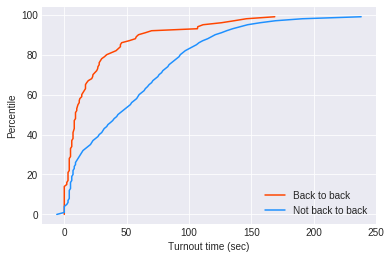

In [175]:
percentiles = np.arange(0,100)
back_to_back = np.percentile(turnout_df[turnout_df['back_to_back']]['turnout_time'], percentiles)
plt.plot(back_to_back, percentiles, color='orangered')

not_back_to_back= np.percentile(turnout_df[turnout_df['back_to_back']==False]['turnout_time'], percentiles)
plt.plot(not_back_to_back, percentiles, color='dodgerblue')
plt.legend(['Back to back', 'Not back to back'])
plt.xlabel('Turnout time (sec)')
plt.ylabel('Percentile')

# Task 2

In [193]:
df['end_on_scene'] = df[['Available DtTm', 'Transport DtTm']].min(axis=1)
df['time_on_scene'] = df['end_on_scene'] - df['On Scene DtTm'] 
df['time_on_scene'] = df['time_on_scene'].progress_apply(lambda x: x.total_seconds())

#Removing outliers to help with analysis
on_scene = df[df['time_on_scene'] < 6000]
on_scene = df[df['time_on_scene'] > 0]
on_scene = on_scene[on_scene['turnout_time'] < 600]
on_scene = on_scene[on_scene['turnout_time'] > 0]


100%|██████████| 10000/10000 [00:00<00:00, 138831.83it/s]


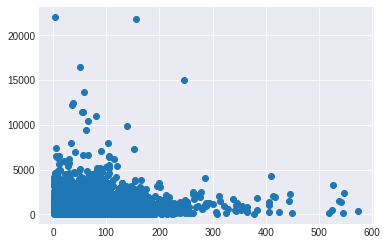

In [194]:
plt.scatter(on_scene['turnout_time'], on_scene['time_on_scene'])

## Pearsons R. Quantifies the correlation between the two quantities
It's slightly negative, so I don't believe that there is a positive relationship between turnout time and time on scene


In [206]:
on_scene[['time_on_scene','turnout_time']].corr().iloc[0,1]

-0.08030995476322363

# Task 3

In [413]:
df['call_duration'] = df['Available DtTm'] - df['Dispatch DtTm']
df['call_duration'] = df['call_duration'].progress_apply(lambda x: x.total_seconds())
call_time_df = df.dropna(subset=['call_duration'], axis=0)

#Use only positive call durations
call_time_df = call_time_df[call_time_df['call_duration'] > 0]


100%|██████████| 10000/10000 [00:00<00:00, 103239.83it/s]


## Feature exploration
Data is skewed, so a log transformation might be a good idea

### Histogram of untransformed data

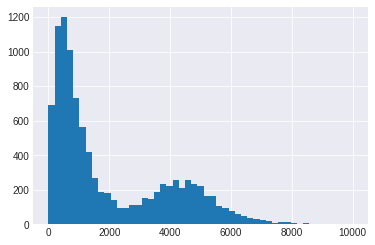

In [414]:
hist = plt.hist(call_time_df['call_duration'], bins = np.linspace(0,10000,50))

### Log histogram
Interesting... Looks like two distinct Gaussians now, so that means two distinct log-normal distributions.

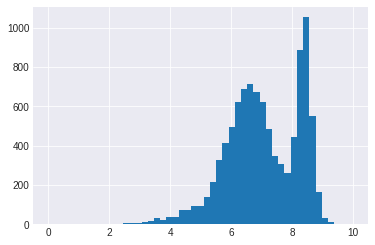

In [415]:
hist = plt.hist(np.log(call_time_df['call_duration']), bins = np.linspace(0,10,50))

### Time of day

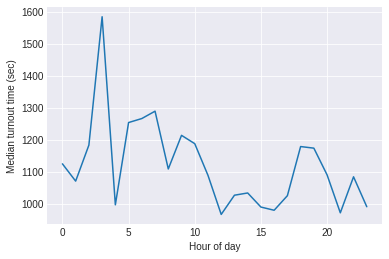

In [416]:
median_call_time = call_time_df[['hour','call_duration']].groupby('hour').aggregate(np.median).reset_index()
plt.plot(median_call_time['hour'], median_call_time['call_duration'])
plt.xlabel('Hour of day')
plt.ylabel('Median turnout time (sec)')

#We'll keep track of the features we want to use in the model
important_features = []
important_features = important_features + list(pd.get_dummies(median_call_time,  columns=['hour']).columns)

### Unit type
PRIVATE and MEDIC appear to be linked to longer call durations, engines are linked to shorter durations

Unit Type_ENGINE    -0.403726
Unit Type_MEDIC      0.503454
Unit Type_PRIVATE    0.271505
Name: call_duration, dtype: float64


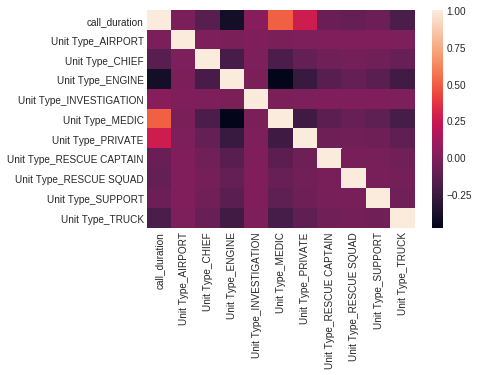

In [417]:
columns = ['call_duration', 'Unit Type']
subset = pd.get_dummies(df[columns])
sns.heatmap(subset.corr())

#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)


### Call type
Medical calls are longer; alarm calls are shorter

Call Type_Alarms             -0.220412
Call Type_Medical Incident    0.303316
Name: call_duration, dtype: float64


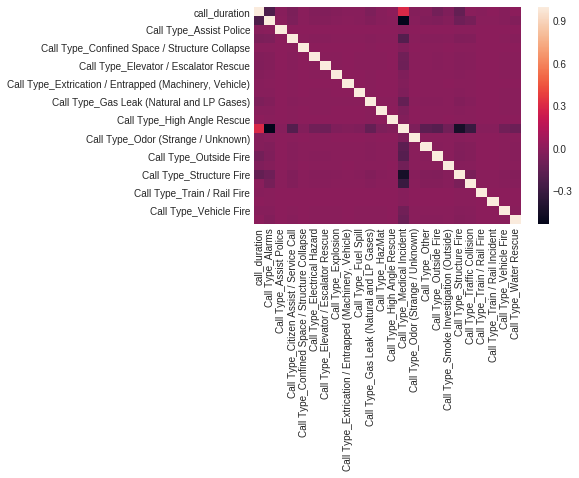

In [418]:
columns = ['call_duration', 'Call Type']
subset = pd.get_dummies(call_time_df[columns])
sns.heatmap(subset.corr())
#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)

### Call priority
Medical calls are longer; alarm calls are shorter

Original Priority_2    0.230940
Original Priority_3   -0.231537
Name: call_duration, dtype: float64


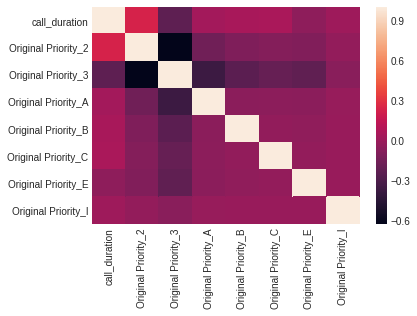

In [419]:
columns = ['call_duration', 'Original Priority']
subset = pd.get_dummies(call_time_df[columns])
sns.heatmap(subset.corr())
#Anything with a absolute value of pearson's R greater than 0.2, we'll include in our model
correlations = subset.corr()['call_duration']
correlations = correlations[np.abs(correlations)>0.2].drop('call_duration')
print(correlations)
important_features = important_features + list(correlations.index)

### Number of alarms
Almost every value is one, so we won't use it

In [420]:
call_time_df['Number of Alarms'].value_counts()

1.0    9977
2.0      14
4.0       1
Name: Number of Alarms, dtype: int64

## Building the model
Random Forest is a good off-the-shelf model when we're short on time

### One-hot encoding the variables
This means that for every category, we make a boolean variable

In [421]:
columns = ['hour', 'Unit Type', 'Call Type']
y = call_time_df['call_duration']
# important_features = important_features[important_features != 'call_duration']
# X = pd.get_dummies(call_time_df[columns], columns=columns)

### Fitting the model. 
In order to evaluate performance, we throw out 20% of the data. The model trains on the remaining 80%. 
Then we evaluate the predictions on the "out of sample" data

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor( n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

(0, 8000)

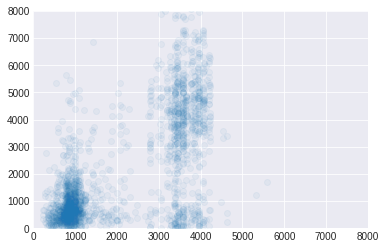

In [430]:
plt.scatter(y_pred, y_test, alpha=0.05)
plt.xlim(0,8000)
plt.ylim(0,8000)

### We'll use the R^2 metric to evaluate the predictions
This is the fraction of the variance that the model is able to explain. 0.45 Is not great, but it's better than I expected. It seems the model is able to group the p

In [424]:
SST = np.sum((y_test-np.mean(y_test))**2)
SSE = np.sum((y_test-y_pred)**2)
print(1-SSE/SST)

0.4585920652709399
